In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

**Pycaret package Installation** <br>

This module uses pycaret package for model training, evaluation and predictions . So the pycaret package need to be installed separately.<br>

<u>Pycaret references:</u>

Click the link(s) to view pycaret references

<a  href='https://pycaret.gitbook.io/docs/get-started/tutorials'>Pycaret Tutorial</a> <br>
<a  href='https://pycaret.readthedocs.io/en/latest/api/regression.html'>Pycaret Regression API</a>

In [3]:
!pip install pycaret

     |████████████████████████████████| 301 kB 18.7 MB/s            
     |████████████████████████████████| 24.2 MB 23.1 MB/s            
     |████████████████████████████████| 636 kB 42.7 MB/s            
     |████████████████████████████████| 25.9 MB 21.3 MB/s            
     |████████████████████████████████| 114 kB 39.2 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 10.4 MB 22.6 MB/s            
     |████████████████████████████████| 167 kB 39.1 MB/s            
     |████████████████████████████████| 15.6 MB 41.7 MB/s            
     |████████████████████████████████| 184 kB 37.9 MB/s            
     |████████████████████████████████| 1.0 MB 33.0 MB/s            
     |████████████████████████████████| 14.8 MB 19.4 MB/s            
     |████████████████████████████████| 58 kB 7.2 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 79 kB 11.6 MB/s            
  Created wheel fo

In [3]:
#import regression api from pycaret
from pycaret.regression import *

In [4]:
#import modules
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
%matplotlib inline

In [5]:
KAGGLE=False

In [6]:
if KAGGLE:
    path='../input/jobathonfebruary2022/'
else:
    path=''

#### Read input files - train, test and submission csv file

In [7]:
train = pd.read_csv(path+'train_0OECtn8.csv')
test = pd.read_csv(path+'test_1zqHu22.csv')
subm = pd.read_csv(path+'sample_submission_JPlpRcN.csv')

In [8]:
print(train.shape)
print(test.shape)

(89197, 10)
(11121, 9)


In [15]:
print(train.columns)
print(test.columns)

Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views', 'engagement_score'],
      dtype='object')
Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views'],
      dtype='object')


 ### **Data Preprocessing**

In [16]:
''''
This function performs label encoding of gender and ordinal encoding for 
fields `gender` and `profession` respectively
It performs processing on both train and test records
''''
def preproc(train,test):
    label_encoder = LabelEncoder()

    train['gender']= label_encoder.fit_transform(train['gender'])
    test['gender']= label_encoder.transform(test['gender'])
    
    #ordinal encoding of profession
    prof_map = {'Other':0,'Student':1,'Working Professional':2}
    train['profession'] = train['profession'].map(prof_map)
    test['profession'] = test['profession'].map(prof_map)
    
    #to have video id without target encoding
    train['video_id_raw']=train['video_id'].copy()
    
''''
This function performs feature generation using aggregate features
on user_id, video_id and category_id
It performs processing on both train and test records
''''
def gen_agg(train,test):
    #user_id aggregate features
    user_agg = train[['user_id','video_id','category_id']].groupby('user_id').agg('nunique').reset_index()
    user_agg = user_agg.rename({'video_id':'user_video_count','category_id':'user_category_count'},axis=1)
    train = pd.merge(train, user_agg, how='left', on='user_id')
    test = pd.merge(test, user_agg, how='left', on='user_id')
    
    
    #category_id aggregate features
    cat_agg = train[['category_id','user_id','video_id','age','gender','profession']] \
                        .groupby('category_id') \
                        .agg({'user_id':'nunique','video_id':'nunique', \
                             'age':'mean','gender':'mean','profession':'mean'}) \
                        .reset_index()
    cat_agg = cat_agg.rename({'user_id':'category_user_count',
                              'video_id':'category_video_count',
                              'age':'category_age_mean',
                              'gender':'category_gender_mean',
                              'profession':'category_profession_mean',
                             }, axis=1)
    train = pd.merge(train, cat_agg, how='left', on='category_id')
    test = pd.merge(test, cat_agg, how='left', on='category_id')    
    
    #video_id aggregate features
    video_agg = train[['video_id','age','gender','profession']] \
                        .groupby('video_id') \
                        .agg('mean') \
                        .reset_index() 
    video_agg = video_agg.rename({'age':'video_age_mean',
                              'gender':'video_gender_mean',
                              'profession':'video_profession_mean',
                             },axis=1)
    train = pd.merge(train, video_agg, how='left', on='video_id')
    test = pd.merge(test, video_agg, how='left', on='video_id')
    
    return train,test
        

In [17]:
preproc(train,test)

In [18]:
train,test = gen_agg(train,test)

In [19]:
print(train.columns)
train.head()

Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views', 'engagement_score', 'video_id_raw',
       'user_video_count', 'user_category_count', 'category_user_count',
       'category_video_count', 'category_age_mean', 'category_gender_mean',
       'category_profession_mean', 'video_age_mean', 'video_gender_mean',
       'video_profession_mean'],
      dtype='object')


,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score,video_id_raw,user_video_count,user_category_count,category_user_count,category_video_count,category_age_mean,category_gender_mean,category_profession_mean,video_age_mean,video_gender_mean,video_profession_mean
0,1,19990,37,128,24,1,1,180,1000,4.33,128,3,2,635,2,24.816008,0.602911,0.922037,24.864811,0.602386,0.912525
1,2,5304,32,132,14,0,1,330,714,1.79,132,5,3,1507,4,24.884218,0.563053,0.862832,25.104735,0.569584,0.892396
2,3,1840,12,24,19,1,1,180,138,4.35,24,3,1,2020,6,24.836205,0.670352,0.883775,25.039640,0.681081,0.935135
3,4,12597,23,112,19,1,1,220,613,3.77,112,3,2,1705,2,25.175964,0.642456,0.897791,25.248317,0.641735,0.893044
4,5,13626,23,112,27,1,2,220,613,3.13,112,4,2,1705,2,25.175964,0.642456,0.897791,25.248317,0.641735,0.893044


In [45]:
#user_id is copied as new column to train and test 
#since user_id would be transformed to target encoding during model training
#and this copied user_id would have the original values (ie) before encoding.
train['user_id_orig']=train['user_id'].copy()
test['user_id_orig']=test['user_id'].copy()

In [21]:
#store target column
targetcol = 'engagement_score'
target = train[targetcol]

assign list of features to be used for model training

In [22]:
exclude_cols =['row_id', 'category_age_mean', 'category_gender_mean',
       'category_profession_mean',  'video_gender_mean',
       'video_profession_mean','video_id_raw',
            'video_age_mean',
        'video_age_ratio', 'video_profession_diff', 
        'video_profession_ratio', 'video_gender_diff', 'video_gender_ratio']
features =[col for col in train.columns if col not in exclude_cols]
print(len(features))
print(features)
features_excl_target = [col for col in features if col!=targetcol]

14
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'engagement_score', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count', 'user_id_orig']


In [23]:
#for pycaret, numeric and categorical columns have to be separately specified
#categorical column list is empty since categorical field 
#gender is already converted to numeric
catcols = []
numeric_cols = [col for col in features if col not in catcols+[targetcol]]
print(len(catcols))
print(catcols)
print(len(numeric_cols))
print(numeric_cols)

0
[]
13
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count', 'user_id_orig']


In [25]:
#create pipeline for target encoding to be used during cross validation
#min_samples_leaf is set to lower value 
#since number of records for user_id starts
#from value 2.
ct = ColumnTransformer(
     [
         ("targetenc",  TargetEncoder(cols=['user_id','category_id', 'video_id'],
                                                min_samples_leaf=2, smoothing=0.1) , ['user_id','category_id', 'video_id']),
      ],remainder='passthrough')

preprocessor = ('preproc',ct)

### Model Training and Predictions

Initialize pycaret API by using `setup()`

Note: additional preprocessing of target encoding to be performed during cross validation is mentioned in the parameter `custom_pipeline`

`remove_perfect_collinearity=False` is required since there are 2 user_id features which are duplicate and one would be converted to target encoding during cross validation. Otherwise one of the field would be removed by pycaret before cross validation.

In [31]:
s = setup(train[features], session_id=100,
          silent=True,
          numeric_features=numeric_cols,
          categorical_features=catcols,
          target = targetcol,
          custom_pipeline=preprocessor,
          fold=10,fold_shuffle=True,
          use_gpu=True,
        remove_perfect_collinearity=False,
        )

,Description,Value
0,session_id,100
1,Target,engagement_score
2,Original Data,"(89197, 14)"
3,Missing Values,False
4,Numeric Features,13
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(62437, 13)"


In [43]:
#checking the preprocessed train dataset from pycaret
#till this stage target encoding would not have been done.
X= get_config('X')
print(len(X.columns))
print(list(X.columns))
X.head()

13
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'user_video_count', 'user_category_count', 'category_user_count', 'category_video_count', 'user_id_orig']


,user_id,category_id,video_id,age,gender,profession,followers,views,user_video_count,user_category_count,category_user_count,category_video_count,user_id_orig
0,19990.0,37.0,128.0,24.0,1.0,1.0,180.0,1000.0,3.0,2.0,635.0,2.0,19990.0
1,5304.0,32.0,132.0,14.0,0.0,1.0,330.0,714.0,5.0,3.0,1507.0,4.0,5304.0
2,1840.0,12.0,24.0,19.0,1.0,1.0,180.0,138.0,3.0,1.0,2020.0,6.0,1840.0
3,12597.0,23.0,112.0,19.0,1.0,1.0,220.0,613.0,3.0,2.0,1705.0,2.0,12597.0
4,13626.0,23.0,112.0,27.0,1.0,2.0,220.0,613.0,4.0,2.0,1705.0,2.0,13626.0


Build and Train LightGBM model with tuned parameters

`Note`: Though LightGBM is not used in final submission, this model has very high potential for improving the predictions in future ensembling.

In [57]:
lgbm = create_model('lightgbm',bagging_fraction=0.6579004691375484, bagging_freq=0,
              boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               feature_fraction=0.4, importance_type='split',
              learning_rate=0.017126008965757278, max_depth=12,
              min_child_samples=1, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=256, objective=None,
              random_state=100, reg_alpha=1e-10, reg_lambda=1e-10,
              silent='warn', subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)
lgbm

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4958,0.4513,0.6718,0.4212,0.1905,0.2410
1,0.4985,0.4408,0.6639,0.4024,0.1806,0.2402
2,0.5062,0.4639,0.6811,0.3984,0.1892,0.2823
3,0.4989,0.4447,0.6669,0.3978,0.1830,0.2237
4,0.4993,0.4474,0.6689,0.4099,0.1850,0.1963
5,0.5035,0.4524,0.6726,0.3932,0.1829,0.2242
6,0.4921,0.4279,0.6542,0.4140,0.1762,0.1899
7,0.4998,0.4474,0.6689,0.4055,0.1843,0.2351
8,0.4910,0.4260,0.6526,0.4115,0.1767,0.2380
9,0.4987,0.4437,0.6661,0.4129,0.1852,0.2607


LGBMRegressor(bagging_fraction=0.6579004691375484, bagging_freq=0,
              boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              feature_fraction=0.4, importance_type='split',
              learning_rate=0.017126008965757278, max_depth=12,
              min_child_samples=1, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=256, objective=None,
              random_state=100, reg_alpha=1e-10, reg_lambda=1e-10,
              silent='warn', subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [58]:
#save tuned light gbm model for future predictions and ensembling
save_model(lgbm, 'tuned_lgbm_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['user_id',
                                                           'category_id',
                                                           'video_id', 'age',
                                                           'gender',
                                                           'profession',
                                                           'followers', 'views',
                                                           'user_video_count',
                                                           'user_category_count',
                                                           'category_user_count',
                                      

Light GBM Feature Importances

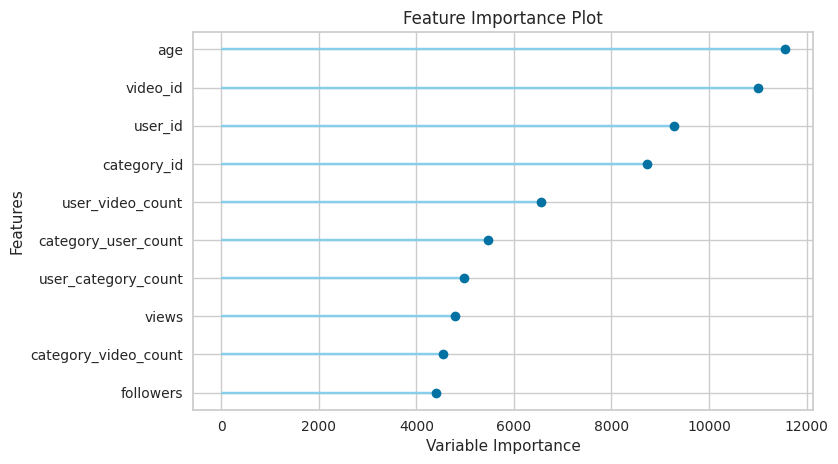

In [59]:
#Top 10 important features of LightGBM according to feature importances
plot_model(lgbm,'feature')

xgboost model

Build and Train XGBoost model with tuned parameters

In [32]:
%%time
xgbm=create_model('xgboost',base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.020277635007304968,
             max_delta_step=0, max_depth=11, min_child_weight=4,
             monotone_constraints='()', n_estimators=300, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=100, reg_alpha=1e-10,
             reg_lambda=1e-10, scale_pos_weight=46.751325738834,
             subsample=0.9840433785610212, tree_method='gpu_hist',
             validate_parameters=1, verbosity=0)
xgbm

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4936,0.4377,0.6616,0.4222,0.1817,0.2498
1,0.4897,0.4434,0.6659,0.4114,0.1828,0.2132
2,0.4918,0.4387,0.6623,0.4167,0.1829,0.1845
3,0.4815,0.4175,0.6462,0.4252,0.1743,0.2583
4,0.5001,0.4540,0.6738,0.3894,0.1842,0.2347
5,0.4843,0.4222,0.6497,0.4271,0.1779,0.2614
6,0.4983,0.4504,0.6711,0.4182,0.1843,0.1960
7,0.4948,0.4444,0.6666,0.4171,0.1856,0.2409
8,0.4922,0.4377,0.6616,0.4087,0.1804,0.2486
9,0.4911,0.4367,0.6609,0.4158,0.1830,0.1882


CPU times: user 6min 14s, sys: 2min 11s, total: 8min 26s
Wall time: 8min 52s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.020277635007304968,
             max_delta_step=0, max_depth=11, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=100, reg_alpha=1e-10,
             reg_lambda=1e-10, scale_pos_weight=46.751325738834,
             subsample=0.9840433785610212, tree_method='gpu_hist',
             validate_parameters=1, verbosity=0)

In [33]:
#save tuned xgboost model for future predictions and ensembling
save_model(xgbm, 'tuned_xgb_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['user_id',
                                                           'category_id',
                                                           'video_id', 'age',
                                                           'gender',
                                                           'profession',
                                                           'followers', 'views',
                                                           'user_video_count',
                                                           'user_category_count',
                                                           'category_user_count',
                                      

XGBoost Feature Importances

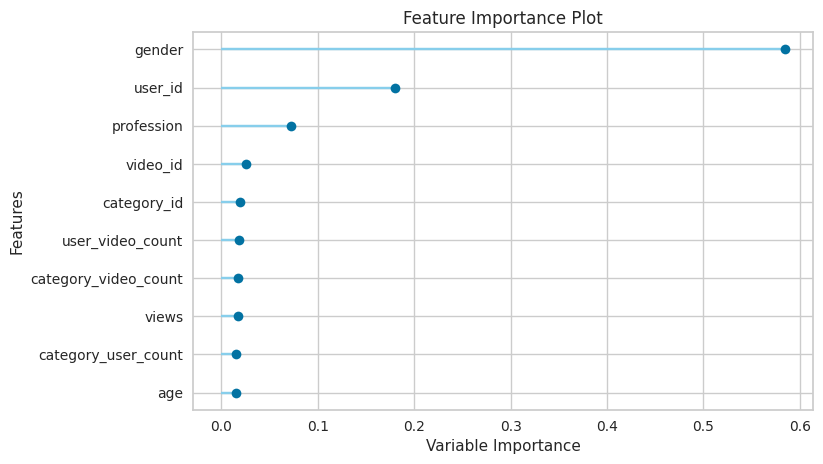

In [33]:
#Top 10 important features of LightGBM according to feature importances
plot_model(xgbm,'feature')

Catboost Model Training

`Note`: Though Catboost is not used in final submission, this model has very high potential for improving the predictions in future ensembling.

In [36]:
# catboost=create_model('catboost')
# catboost

In [37]:
# save_model(catboost, 'catboost_model')

Random Forest Model Training

`Note`: Though Random Forest is not used in final submission, this model has very high potential for improving the predictions in future ensembling.

In [38]:
# rf=create_model('rf')
# rf

In [39]:
# save_model(rf, 'randomforest_model')

Ensemble models

Stacking of multiple models with restacking (i.e) including original features along with the predictions during stacking

In [40]:
# stacked_model = stack_models([lgbm,xgbm,catboost,rf],
# #                               meta_model=
#                             ),
# stacked_model

In [41]:
# save_model(stacked_model, 'stacked_model_w_tuned_xgbm')

### Predictions

For predicting test data, train the model using full train data. <br>
In pycaret, it is achieved by invoking `finalize_model()`

In [ ]:
%%time
# final_model = finalize_model(stacked_model[0])
#train the model using test predictions based on tuned xgboost model
final_model = finalize_model(xgbm)

Make predictions on the test data using final model <br>

pycaret `predict_model` returns predictions in the column `Label` and return value contains  test input data besides prediction

In [46]:
test_preds = predict_model(final_model, data=test)
print(test_preds.head())

   row_id  user_id  category_id  video_id  age  gender  profession  followers  \
0   89198     7986           12        42   14       1           1        180   
1   89199    11278           34       115   14       1           1        230   
2   89200    17245            8       110   44       0           2        280   
3   89201     9851           16       137   18       1           1        270   
4   89202    16008           34        96   47       0           0        230   

   views  user_video_count  ...  category_user_count  category_video_count  \
0    138                 2  ...                 2020                     6   
1    840                 5  ...                 1679                     5   
2    628                 5  ...                 3043                    10   
3    462                 3  ...                 1670                     5   
4    840                 3  ...                 1679                     5   

   category_age_mean  category_gender_mean  

In [47]:
final_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.020277635007304968,
             max_delta_step=0, max_depth=11, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=100, reg_alpha=1e-10,
             reg_lambda=1e-10, scale_pos_weight=46.751325738834,
             subsample=0.9840433785610212, tree_method='gpu_hist',
             validate_parameters=1, verbosity=0)

In [52]:
# %%time
# #train predictions
# train_preds = predict_model(final_model, data=train)
# print(train_preds.head())
# print('full train score:',r2_score(target,train_preds['Label']))

#### Create and Save Submission File using test predictions

In [48]:
submission = test_preds[['row_id','Label']]
submission=submission.rename(columns={'Label':'engagement_score'})
submission[['row_id','engagement_score']].to_csv('submission.csv',index=False)

read and check the submission file

In [49]:
test_sub = pd.read_csv('submission.csv')

In [50]:
print(test_sub.shape)
test_sub.head()

(11121, 2)


,row_id,engagement_score
0,89198,4.197085
1,89199,3.970400
2,89200,2.388274
3,89201,2.889002
4,89202,2.074492
